# EfficientNet

In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

In [3]:
# Define paths to the dataset
train_dir = '../datasets/cinic-10/train'
valid_dir = '../datasets/cinic-10/valid'
test_dir = '../datasets/cinic-10/test'

# Define image size and batch size
image_size = (32, 32)
batch_size = 64

In [4]:
# Create ImageDataGenerator instances with data augmentation for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    )


In [5]:
# Create generators for training, validation, and test data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)
train_generator.shuffle = True

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)
valid_generator.shuffle = True

test_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator.shuffle = True

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


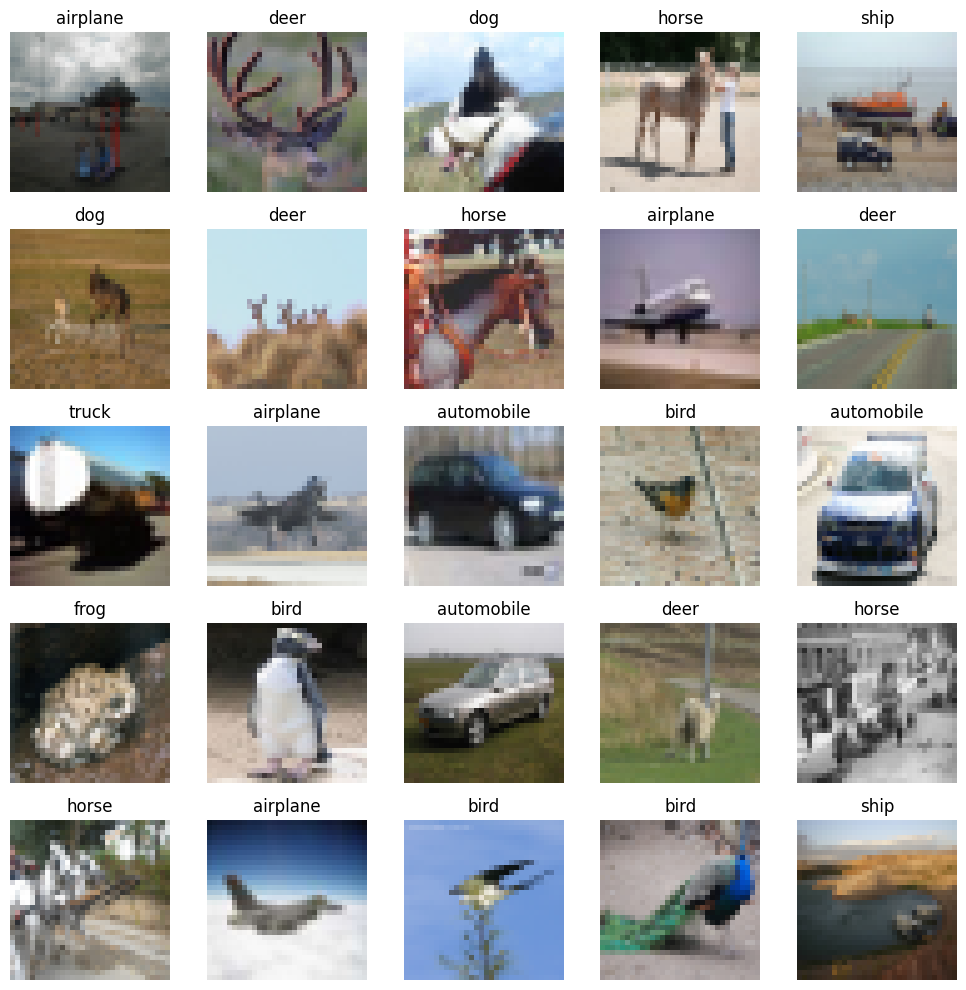

In [13]:
import matplotlib.pyplot as plt
class_labels = list(train_generator.class_indices.keys())

# Get a batch of images and labels from the test generator
images, labels = next(train_generator)

# Display 25 images from the batch
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.ravel()

for i in range(25):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    axes[i].set_title(class_labels[np.argmax(labels[i])])

plt.tight_layout()
plt.show()

In [6]:
# Load MobileNetV3Large without top classification layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model layers
base_model.trainable = False


In [7]:
# Add additional layers on top of EfficientNet
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='softmax')  # Output layer with size 10 for classification
])
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    # validation_data=valid_generator,
    batch_size=batch_size
)

Epoch 1/5


/Users/salveendutt/GithubRepos/Deep-Learning/.tfenv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - accuracy: 0.3616 - loss: 1.8589
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.4332 - loss: 1.5753
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.4505 - loss: 1.5279
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - accuracy: 0.4602 - loss: 1.5005
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - accuracy: 0.4680 - loss: 1.4772


KeyError: 'val_accuracy'

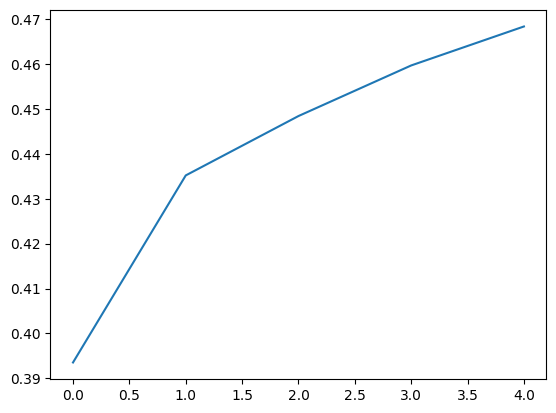

In [9]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [10]:
# Predict probabilities for test data
predictions = model.predict(test_generator)

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step


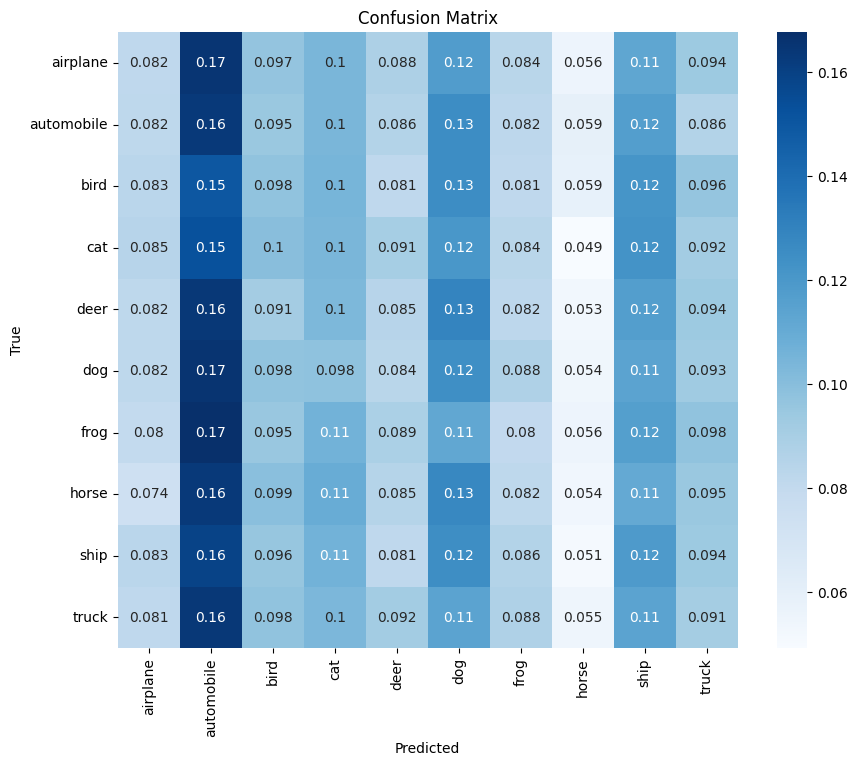

In [11]:
# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true class labels
true_classes = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
